In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import os

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
def load_data(fpath='data/SP1.csv'):
    if os.path.isfile(fpath):
        return pd.read_csv(fpath)
    return None

In [4]:
df = load_data()
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,16/08/2019,20:00,Ath Bilbao,Barcelona,1,0,H,0,0,...,1.97,0.75,1.93,2.00,1.91,2.01,2.02,2.03,1.91,1.98
1,SP1,17/08/2019,16:00,Celta,Real Madrid,1,3,A,0,1,...,2.63,1.00,1.82,1.97,1.85,2.07,2.00,2.20,1.82,2.06
2,SP1,17/08/2019,18:00,Valencia,Sociedad,1,1,D,0,0,...,1.82,-0.75,1.94,1.99,1.92,2.00,1.96,2.12,1.89,2.00
3,SP1,17/08/2019,19:00,Mallorca,Eibar,2,1,H,1,0,...,1.66,0.00,2.11,1.82,2.09,1.83,2.12,1.88,2.07,1.83
4,SP1,17/08/2019,20:00,Leganes,Osasuna,0,1,A,0,0,...,1.46,-0.50,1.89,2.04,1.90,2.01,1.95,2.06,1.90,1.99


In [5]:
def prepare_data(df: pd.DataFrame):
    df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'}, inplace=True)
    team_categorical = pd.Categorical(df.HomeTeam)
    df['HomeTeamId'] = team_categorical.codes
    df['AwayTeamId'] = pd.Categorical(df.AwayTeam, dtype=team_categorical.dtype).codes
    return df

In [6]:
df = prepare_data(df)
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomeTeamId,AwayTeamId
0,Ath Bilbao,Barcelona,1,0,1,3
1,Celta,Real Madrid,1,3,5,14
2,Valencia,Sociedad,1,1,17,16
3,Mallorca,Eibar,2,1,12,6
4,Leganes,Osasuna,0,1,10,13


In [7]:
n_teams = len(df.HomeTeam.unique())
print(f'Total teams = {n_teams}')

Total teams = 20


## Model 1

No home advantage. 

attack_group_mean ~ Normal(0, 1)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 1)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)

In [8]:
with pm.Model() as model_1:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team = pm.Normal('attack_team', mu=attack_group_mean, sd=attack_group_sd, shape=n_teams)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team = pm.Normal('defense_team', mu=defense_group_mean, sd=defense_group_sd, shape=n_teams)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Usi

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fb463ab90>,
      dtype=object)

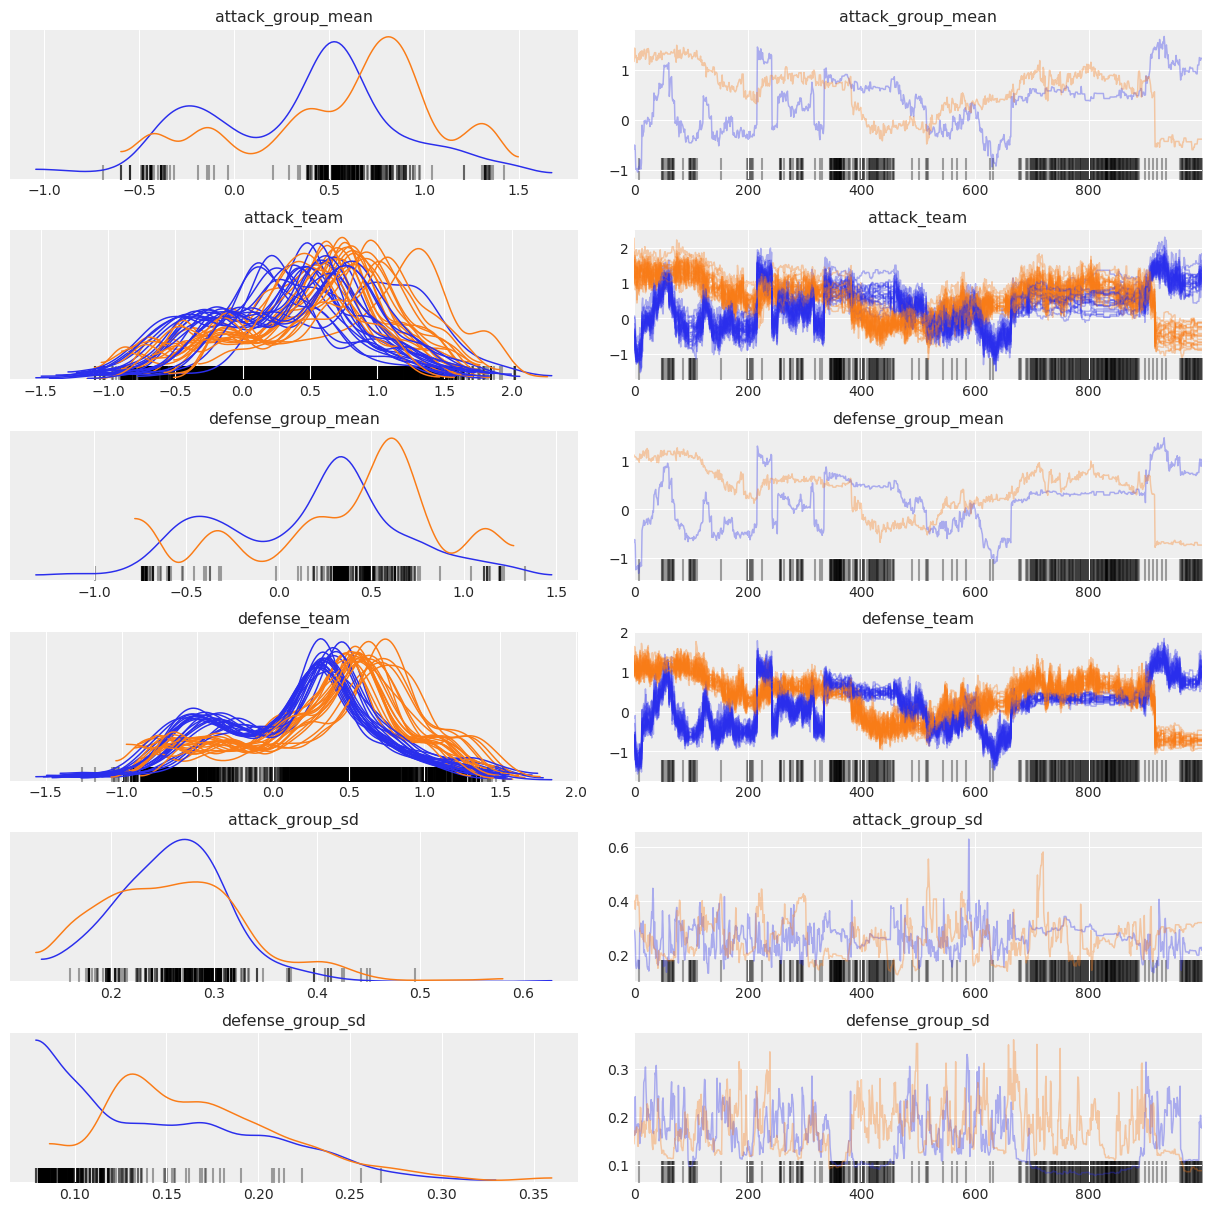

In [9]:
az.plot_trace(trace_1, compact=True)

* Too many divergences in model 1.
* Chains do not converge and mix properly.
* R hat statistic too large

Need to reparametrize the model

## Model 1 non-centered parametrization

In [10]:
with pm.Model() as model_1_nc:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team = pm.Deterministic('attack_team', attack_group_mean + attack_group_sd * attack_team_z)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team = pm.Deterministic('defense_team', defense_group_mean + defense_group_sd * defense_team_z)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1_nc = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fb5b67350>,
      dtype=object)

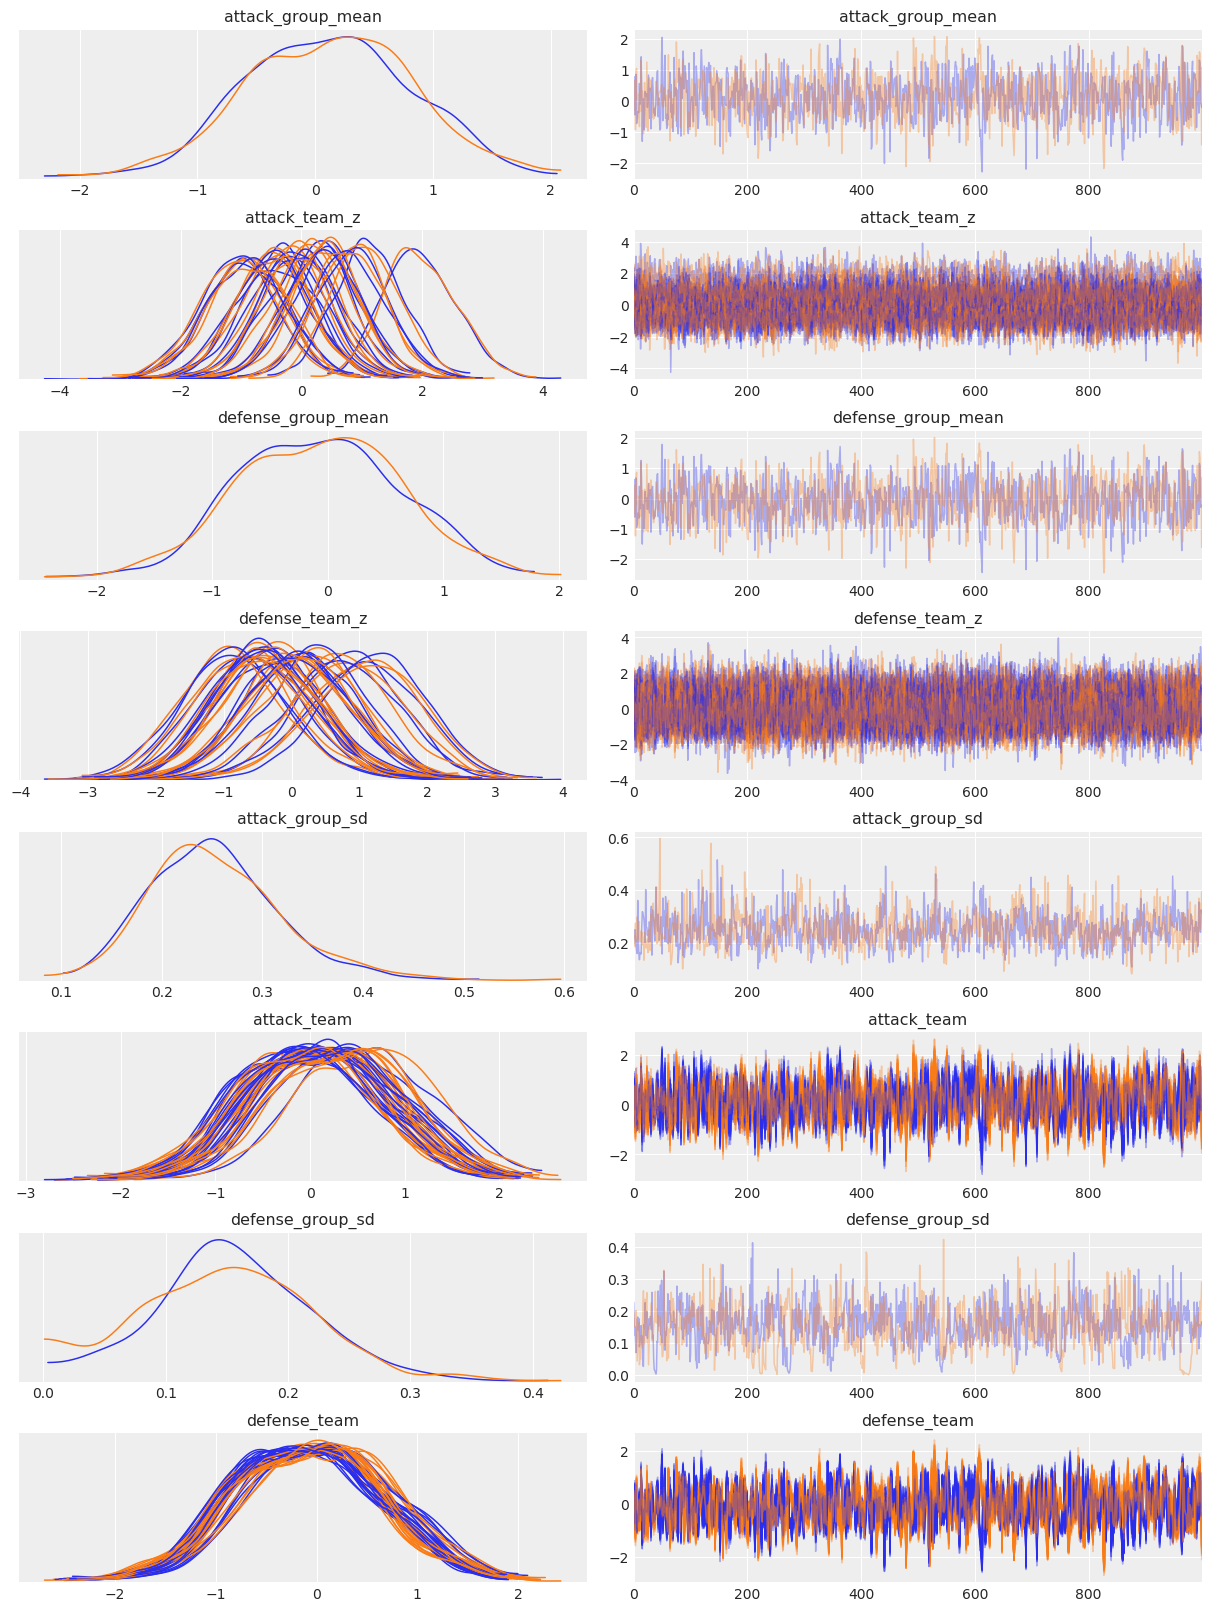

In [11]:
az.plot_trace(trace_1_nc, compact=True)

Text(0, 0.5, 'Density')

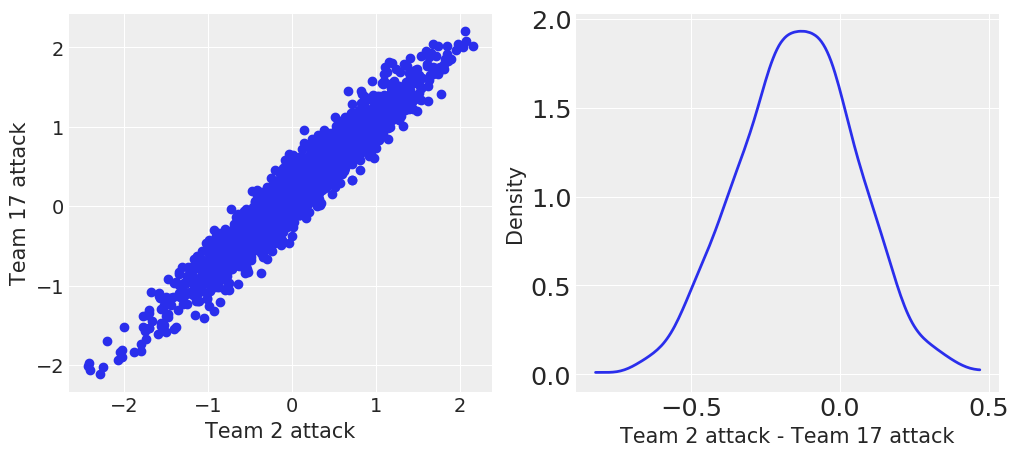

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_1_nc['attack_team'][:, 2], trace_1_nc['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_1_nc['attack_team'][:, 2] - trace_1_nc['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

* Too much variance in parameter estimates.
* Model is unidentifiable. Adding any constant k to all the attack and defense parameters will lead to the same predictions
* Need to add some more constraints.

## Model 2

* No home team advantage.
* Add sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 1)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 1)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [13]:
import theano.tensor as tt

In [14]:
with pm.Model() as model_2:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    #attack_team = pm.Deterministic('attack_team', tt.concatenate([attack_team_, tt.stack(-tt.sum(attack_team_))]))
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    #defense_team = pm.Deterministic('defense_team', tt.concatenate([defense_team_, tt.stack(-tt.sum(defense_team_))]))
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_2 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fac656250>,
      dtype=object)

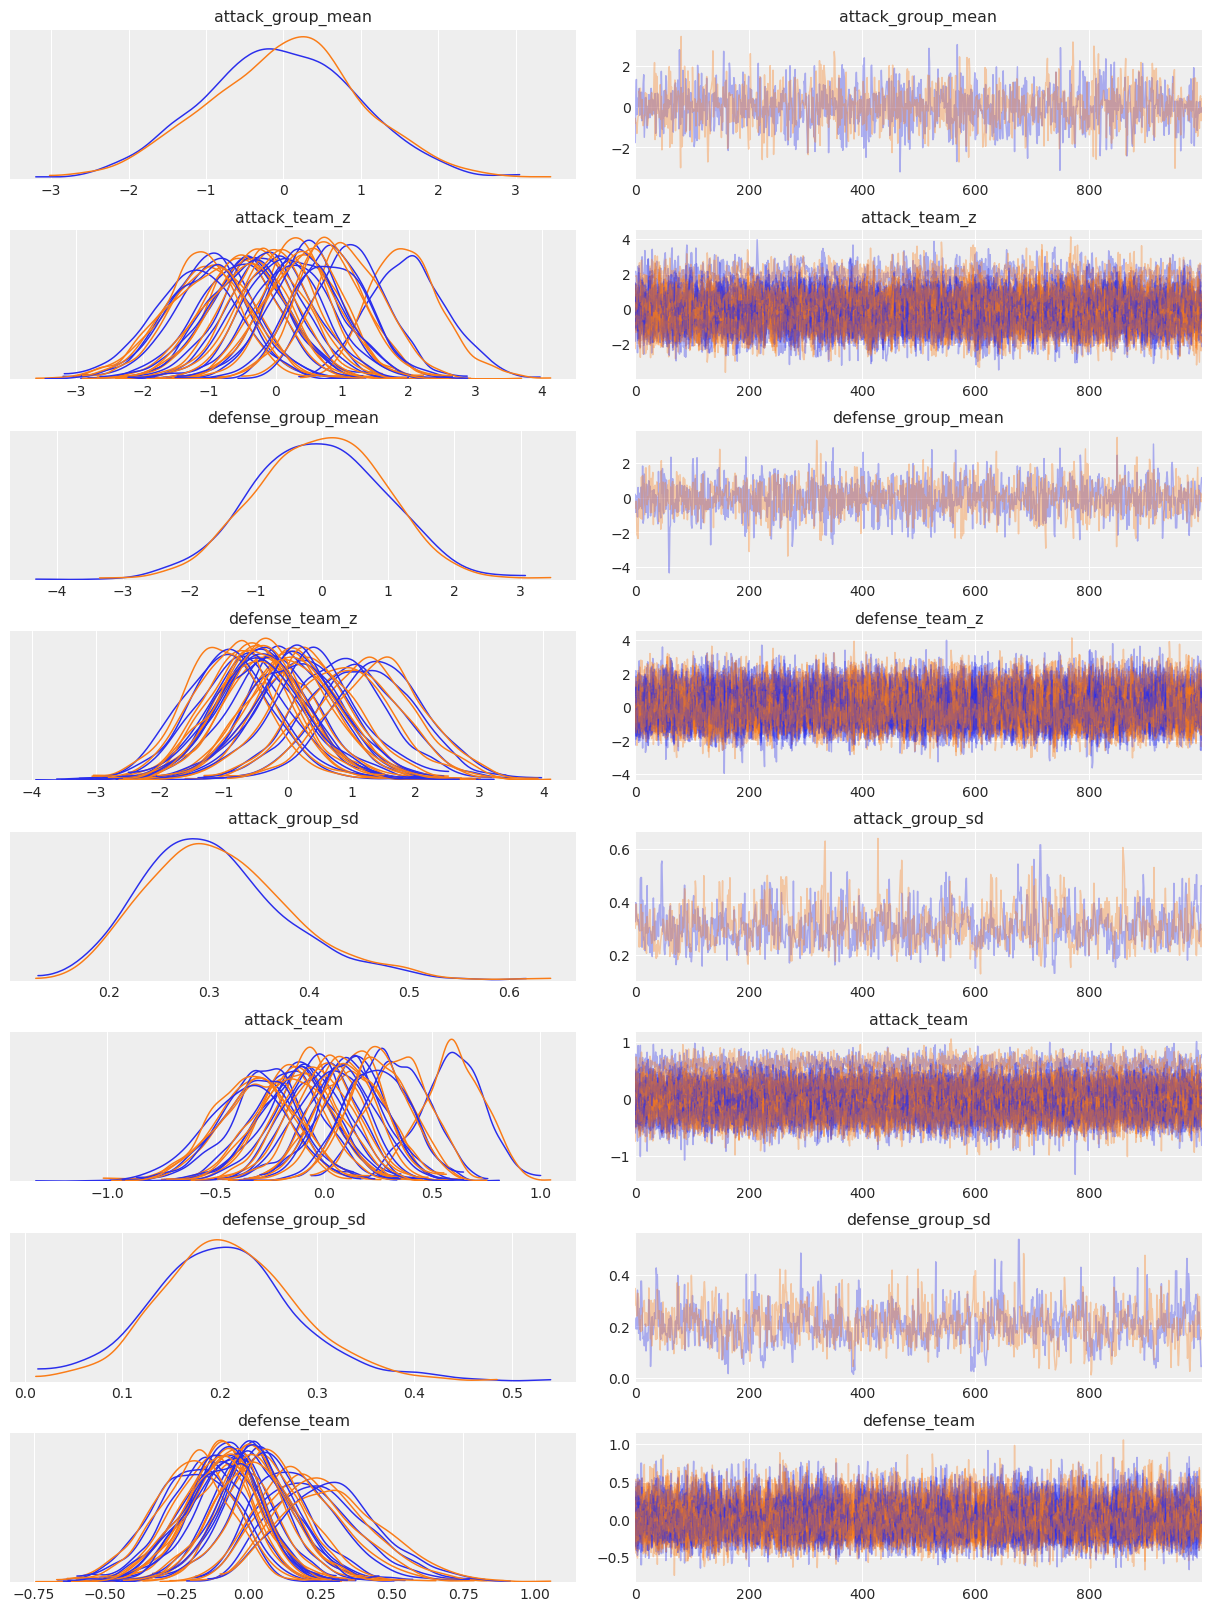

In [15]:
az.plot_trace(trace_2, compact=True)

In [16]:
az.summary(trace_2, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'],
           credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
attack_group_mean,-0.008,0.993,-1.662,1.487,0.021,0.022,2344.0,1016.0,2347.0,1700.0,1.0
attack_group_sd,0.308,0.074,0.192,0.416,0.003,0.002,670.0,670.0,676.0,1027.0,1.0
attack_team[0],-0.123,0.169,-0.387,0.158,0.003,0.003,2349.0,1260.0,2355.0,1167.0,1.0
attack_team[1],-0.125,0.162,-0.388,0.120,0.003,0.003,2695.0,1586.0,2704.0,1449.0,1.0
attack_team[2],-0.076,0.158,-0.320,0.178,0.003,0.003,2557.0,1220.0,2603.0,1506.0,1.0
attack_team[3],0.597,0.143,0.369,0.832,0.003,0.002,2167.0,2167.0,2113.0,1562.0,1.0
attack_team[4],0.117,0.157,-0.124,0.374,0.003,0.003,2245.0,1763.0,2266.0,1436.0,1.0
attack_team[5],-0.322,0.179,-0.605,-0.050,0.004,0.003,2399.0,2078.0,2249.0,1611.0,1.0
attack_team[6],-0.172,0.168,-0.443,0.093,0.003,0.003,2875.0,1704.0,2921.0,1583.0,1.0
attack_team[7],-0.280,0.177,-0.574,-0.008,0.004,0.003,2227.0,1706.0,2258.0,1749.0,1.0


In [17]:
az.summary(trace_2, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'],
           credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
defense_group_mean,-0.036,0.978,-1.477,1.570,0.021,0.022,2257.0,994.0,2273.0,1328.0,1.0
defense_group_sd,0.207,0.074,0.102,0.332,0.003,0.002,526.0,526.0,511.0,539.0,1.0
defense_team[0],-0.056,0.138,-0.294,0.145,0.003,0.003,2081.0,1011.0,2091.0,1316.0,1.0
defense_team[1],0.209,0.167,-0.052,0.460,0.005,0.003,1264.0,1264.0,1264.0,1354.0,1.0
defense_team[2],0.259,0.167,-0.014,0.503,0.005,0.004,957.0,957.0,916.0,1219.0,1.0
defense_team[3],0.050,0.135,-0.170,0.254,0.003,0.003,2327.0,1390.0,2326.0,1536.0,1.0
defense_team[4],-0.142,0.134,-0.332,0.093,0.003,0.002,2191.0,1938.0,2145.0,1514.0,1.0
defense_team[5],0.001,0.130,-0.221,0.197,0.003,0.003,2665.0,946.0,2703.0,1326.0,1.0
defense_team[6],-0.115,0.134,-0.317,0.109,0.003,0.002,1907.0,1600.0,1939.0,1648.0,1.0
defense_team[7],-0.206,0.141,-0.410,0.029,0.004,0.003,1364.0,1364.0,1317.0,1485.0,1.0
